In [185]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import random

## read recommendationMovie.csv file 

In [186]:
recommendationMovie = pd.read_csv('recommendationMovie.csv', header=None, dtype=np.int32)

In [187]:
print(recommendationMovie.head())

   0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      1      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   14989  14990  14991  14992  14993  14994  14995  14996  14997  14998  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 14999 columns]


In [188]:
print(recommendationMovie.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Columns: 14999 entries, 0 to 14998
dtypes: int32(14999)
memory usage: 57.5 MB
None


In [189]:
recommendationMovie = np.array(recommendationMovie)

In [190]:
#1 stochastic: epsilon greedy (partial feedbacks)
class algorithmsPartialFeedback:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.movieNum, self.day = dataframe.shape
    def print(self):
        return self.movieNum

In [191]:
algorithmsPartialFeedback(recommendationMovie).print()

1005

## partial-feedbacks algorithms

In [192]:
class algorithmsPartialFeedback:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.movieNum, self.day = dataframe.shape
        
    # epsilon greedy
    def epsilon_greedy_partial_stochastic(self): 
        #initialization parameters 
        mu = np.zeros(self.movieNum)
        times = np.zeros(self.movieNum)
        epsilon = 0
        record = []
        for i in range(1, self.day):
            epsilon = (1 / i)*0.9 + 0.1  
            arm = choose_exploration_or_exploitation(epsilon, self.movieNum, mu)
            times[arm] += 1
            record.append(self.dataframe[arm, i])
            mu[arm] += (self.dataframe[arm, i] - mu[arm]) / times[arm]  
        best_arm = np.argmax(np.sum(self.dataframe, axis=1))  
        best = 0 
        success = 0
        loss = np.zeros(self.movieNum)
        regret = []    
        algorithm_loss_cum = 0
        optimal_loss = np.zeros(self.day-1)
        algorithm_loss = np.zeros(self.day-1)
        for i in range(len(record)):
            success += record[i]
            best += self.dataframe[best_arm, i]
            loss += np.ones(self.movieNum) - self.dataframe[:,i].T
            optimal_arm = np.argmin(loss)
            optimal_loss[i] = loss[optimal_arm]
            regret.append((best-success)/(i+1))
            algorithm_loss_cum += 1 - record[i]
            algorithm_loss[i] = algorithm_loss_cum
        return regret, optimal_loss, algorithm_loss
    
    # exploration 
    def exploration(self):
        return np.random.randint(self.movieNum)
    # exploitation 
    def exploitation(self):
        return np.argmax(self.mu)
    # choose exploration or exploitation 
    def choose_exploration_or_exploitation(self, epsilon, mu):
        if np.random.random() > epsilon:
            return exploration(self.movieNum)
        else:
            return exploitation(mu)
        
    #Multiplicative weight updatas Non-stochastic case(partial feedbacks)
    def multiplicative_weight_updatas_partial_stochastic(self):
        reg = []
        w = np.ones(self.movieNum)
        eta = 1/np.sqrt(self.day)
        sumTrueLoss = np.zeros(self.movieNum)
        reward = 0
        trueLoss = np.zeros(self.movieNum)
        sumAllLoss = 0
        algorithm_loss = np.zeros(self.day)
        for i in range(self.day):
            Loss = np.zeros(self.movieNum)
            arm = np.random.choice(self.movieNum, p=w/np.sum(w))
            reward += self.dataframe[arm, i]
            Loss[arm] = 1 - self.dataframe[arm, i]
            trueLoss = 1- self.dataframe[:, i]
            sumTrueLoss += trueLoss                      #loss of the algorithm
            w = w*(1 - eta*Loss.T)                    #update weight 
            sumAllLoss += Loss[arm]                      #total loss of all arms 
            algorithm_loss[i] = sumAllLoss
            loss_L = sumAllLoss - np.min(sumTrueLoss)      #difference between algorithm and the arm with minimum loss
            reg.append(loss_L/(i+1))
        return reg, algorithm_loss
    
    
    #UCB1 Stochastic Partial Feedback
    #go over all arms once first 
    def goOverAllArms(self):
        record = np.zeros(self.day)
        allArmsSequence = random.sample(range(self.movieNum), self.movieNum)
        times = np.zeros(self.movieNum)
        reward = np.zeros(self.movieNum)
        mu = np.zeros(self.movieNum)
        for i in range(self.movieNum):
            arm = allArmsSequence[i]
            reward[arm] += self.dataframe[arm, i]
            times[arm] += 1
            mu[arm] = reward[arm] / 1  
            record[i] = self.dataframe[arm, i]
        return reward, times, mu, record
    def ucb(mean, n, nj):
        return mean + np.sqrt(2*np.log(n) / nj)
    def ucb1_partial_stochastic(self):
        reward, times, mu, record = goOverAllArms(self.dataframe)
        ucbValue = np.zeros(self.movieNum)
        for i in range(self.movieNum+1,self.day):
            for j in range(self.movieNum):
                ucbValue[j] = ucb(mu[j], i, times[j])
            maxValue = max(ucbValue)
            arm = random.sample([m for m, n in enumerate(ucbValue) if n == maxValue], 1)         
            times[arm] += 1
            mu[arm] = mu[arm] + (self.dataframe[arm, i] - mu[arm])/times[arm]
            record[i] = self.dataframe[arm, i]
        best_arm = np.argmax(np.sum(self.dataframe, axis=1))
        best = 0 
        success = 0
        loss = 0
        regret = []    
        algorithm_loss = np.zeros(self.day)
        for i in range(len(record)):
            success += record[i]
            loss += (1- record[i])
            algorithm_loss[i] = loss
            best += self.dataframe[best_arm, i]
            regret.append((best-success)/(i+1))
        return regret, algorithm_loss
    
    #EXP3 Non-stochastic case partial feedback 
    def exp3_partial_non_stochastic(self):

        prob = np.ones(self.movieNum)/self.movieNum         # Initialize unifor distribution 
        estimated_sum_loss = np.zeros(self.movieNum)
        reward = np.zeros(self.day)
        best_arm = np.argmax(np.sum(self.dataframe, axis=1))
        algorithm_loss = np.zeros(self.day)
        for t in range(self.day):
            eta = (np.log(self.movieNum)/((t+1)*self.movieNum))**0.5      # learning rate
            i = np.random.choice(self.movieNum, p=prob)
            loss = 1 - self.dataframe[i,t]
            reward[t] = self.dataframe[i,t]
            estimated_sum_loss[i] += loss/prob[i]         # unbiased estimator of loss
            weight = [np.exp(-eta*estimated_sum_loss[j]) for j in range(self.movieNum)]
            prob = weight/sum(weight)
        success = 0
        regret = []
        best = 0
        loss = 0
        for i in range(self.day):
            success += reward[i]
            loss += (1- reward[i])
            algorithm_loss[i] = loss
            best += self.dataframe[best_arm, i]
            regret.append((best-success)/(i+1))
        return regret, algorithm_loss
    
    # Thompson
    def Thompson_partial(self):
        #num_ads,T=dataframe.shape
        best_arm = np.argmax(np.sum(self.dataframe, axis=1))
        s = np.zeros(shape=self.movieNum)
        f = np.zeros(shape=self.movieNum)
        reward = np.zeros(shape=self.day)
        reg = []
        success = 0
        best = 0
        algorithm_loss = np.zeros(self.day)
        loss = 0
        for t in range(self.day):
            i = np.argmax([np.random.beta(s[i]+1,f[i]+1) for i in range(self.movieNum)])   # beta distribution
            reward[t] = self.dataframe[i,t]
            if self.dataframe[i,t] == 1:
                s[i]+=1
            else:
                f[i]+=1
        for i in range(self.day):
            success += reward[i]
            loss += (1 - reward[i])
            algorithm_loss[i] = loss 
            best += self.dataframe[best_arm, i]
            reg.append((best-success)/(i+1))
        return reg, algorithm_loss

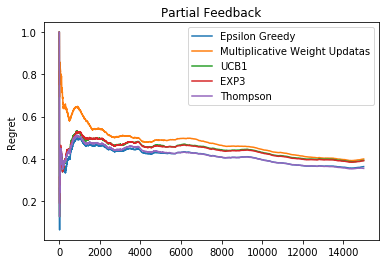

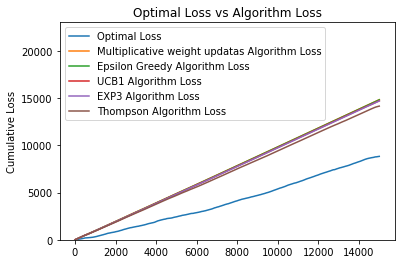

In [193]:
reg1, optimal_loss, algorithm_loss = algorithmsPartialFeedback(recommendationMovie).epsilon_greedy_partial_stochastic()
reg2, algorithm_loss_epsilon = algorithmsPartialFeedback(recommendationMovie).multiplicative_weight_updatas_partial_stochastic()
reg3, algorithm_loss_ucb1 = algorithmsPartialFeedback(recommendationMovie).ucb1_partial_stochastic()
reg4, algorithm_loss_exp3 = algorithmsPartialFeedback(recommendationMovie).exp3_partial_non_stochastic()
reg5, algorithm_loss_thompson = algorithmsPartialFeedback(recommendationMovie).Thompson_partial()
plt.plot(list(range(len(reg1))), reg1,label='Epsilon Greedy')
plt.plot(list(range(len(reg2))), reg2,label='Multiplicative Weight Updatas')
plt.plot(list(range(len(reg3))), reg3,label='UCB1')
plt.plot(list(range(len(reg4))), reg4,label='EXP3')
plt.plot(list(range(len(reg5))), reg5,label='Thompson')
plt.title('Partial Feedback')
plt.ylabel('Regret')
plt.legend()
plt.show()

plt.plot(list(range(len(optimal_loss))), optimal_loss,label='Optimal Loss')
plt.plot(list(range(len(algorithm_loss_MWU))), algorithm_loss_MWU,label='Multiplicative weight updatas Algorithm Loss')
plt.plot(list(range(len(algorithm_loss_epsilon))), algorithm_loss_epsilon,label='Epsilon Greedy Algorithm Loss')
plt.plot(list(range(len(algorithm_loss_ucb1))), algorithm_loss_ucb1,label='UCB1 Algorithm Loss')
plt.plot(list(range(len(algorithm_loss_exp3))), algorithm_loss_exp3,label='EXP3 Algorithm Loss')
plt.plot(list(range(len(algorithm_loss_thompson))), algorithm_loss_thompson,label='Thompson Algorithm Loss')
plt.title('Optimal Loss vs Algorithm Loss')
plt.ylabel('Cumulative Loss')
plt.ylim(0,23000)
plt.legend()
plt.show()

## full-feedbacks algorithms 

In [194]:
class algorithmsFullFeedback:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.movieNum, self.day = dataframe.shape

    #Multiplicative weight updatas stochastic case(full feedbacks)
    def multiplicative_weight_updatas_full_non_stochastic(self):
        reg = []
        w = np.ones(self.movieNum)
        eta = 1/np.sqrt(self.day)
        sumAllLoss = np.zeros(self.movieNum)
        reward = 0
        sumLoss = 0
        times = np.zeros(self.day)
        fullProbability = np.zeros((self.day,self.movieNum))
        algorithm_loss = np.zeros(self.day)
        loss_algorithm = 0
        for i in range(self.day):
            arm = np.random.choice(self.movieNum, p=w/np.sum(w))
            fullProbability[i,:] = w/np.sum(w)
            times[arm] += 1
            reward += self.dataframe[arm, i]
            loss_algorithm += (1 - self.dataframe[arm, i])
            algorithm_loss[i] = loss_algorithm
            Loss = 1 - self.dataframe[:, i]
            sumLoss += Loss[arm]                      #loss of the algorithm
            w = w*(1 - eta*Loss.T)                    #update weight 
            sumAllLoss += Loss.T                      #total loss of all arms 
            loss_L = sumLoss - np.min(sumAllLoss)      #difference between algorithm and the arm with minimum loss
            reg.append(loss_L/(i+1))
        return reg,times, fullProbability, algorithm_loss
    
    #UCB1 Stochastic Full Feedback
    def ucb1_partial_non_stochastic(self):
        reward, times, mu, record = goOverAllArms(self.dataframe)
        ucbValue = np.zeros(self.movieNum)
        algorithm_loss = np.zeros(self.day)
        loss = 0
        for i in range(self.movieNum+1,self.day):
            for j in range(self.movieNum):
                ucbValue[j] = ucb(mu[j], i, times[j])
            maxValue = max(ucbValue)
            arm = random.sample([m for m, n in enumerate(ucbValue) if n == maxValue], 1)         
            mu = mu + (self.dataframe[:, i].T - mu)/i
            record[i] = self.dataframe[arm, i]
        best_arm = np.argmax(np.sum(self.dataframe, axis=1))
        best = 0 
        success = 0
        regret = []    
        for i in range(self.day):
            success += record[i]
            loss += (1 - record[i])
            algorithm_loss[i] = loss
            best += self.dataframe[best_arm, i]
            regret.append((best-success)/(i+1))
        return regret, algorithm_loss
    
    #Thompson stochastic (Full feedback)
    def Thompson_full(self):
        #num_ads,T=dataframe.shape
        best_arm = np.argmax(np.sum(self.dataframe, axis=1))
        s = np.zeros(shape=self.movieNum)
        f = np.zeros(shape=self.movieNum)
        reward = np.zeros(shape=self.day)
        algorithm_loss = np.zeros(self.day)
        loss = 0
        reg = []
        success = 0
        best = 0
        for t in range(self.day):
            i = np.argmax([np.random.beta(s[i]+1,f[i]+1) for i in range(self.movieNum)])   # beta distribution
            reward[t] = self.dataframe[i,t]
            for j in range(self.movieNum):
                if self.dataframe[j,t] == 1:
                    s[j]+=1
                else:
                    f[j]+=1
        for i in range(self.day):
            success += reward[i]
            loss += (1 - reward[i])
            algorithm_loss[i] = loss
            best += self.dataframe[best_arm, i]
            reg.append((best-success)/(i+1))
        return reg, algorithm_loss

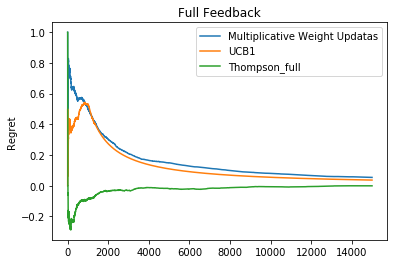

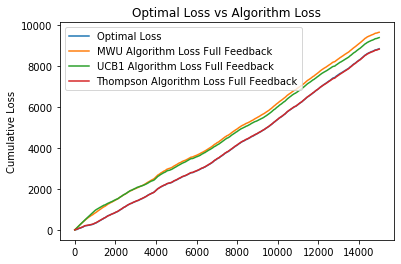

In [195]:
reg6, times, fullProbability, algorithm_loss_mwu = algorithmsFullFeedback(recommendationMovie).multiplicative_weight_updatas_full_non_stochastic()
reg7, algorithm_loss_ucb1 = algorithmsFullFeedback(recommendationMovie).ucb1_partial_non_stochastic()
reg8, algorithm_loss_thompson = algorithmsFullFeedback(recommendationMovie).Thompson_full()
plt.plot(list(range(len(reg6))), reg6,label='Multiplicative Weight Updatas')
plt.plot(list(range(len(reg7))), reg7,label='UCB1')
plt.plot(list(range(len(reg8))), reg8,label='Thompson_full')
plt.title('Full Feedback')
plt.ylabel('Regret')
plt.legend()
plt.show()

plt.plot(list(range(len(optimal_loss))), optimal_loss,label='Optimal Loss')
plt.plot(list(range(len(algorithm_loss_mwu))), algorithm_loss_mwu,label='MWU Algorithm Loss Full Feedback')
plt.plot(list(range(len(algorithm_loss_ucb1))), algorithm_loss_ucb1,label='UCB1 Algorithm Loss Full Feedback')
plt.plot(list(range(len(algorithm_loss_thompson))), algorithm_loss_thompson,label='Thompson Algorithm Loss Full Feedback')
plt.title('Optimal Loss vs Algorithm Loss')
plt.ylabel('Cumulative Loss')
#plt.ylim(0,23000)
plt.legend()
plt.show()

## recommend top-10 movies 

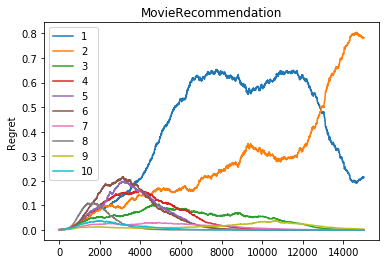

In [196]:
movieProbability = np.sum(fullProbability, axis=0)
sortedTimes = np.sort(times)
sortedTimesDesc = sortedTimes[::-1]
top10 = sortedTimesDesc[:10]
movieNum, day = recommendationMovie.shape
indexList = []
top10Probabiltiy = np.zeros((10, day))
indexList = []
for i in range(10):
    condition = top10[i]
    index = np.where(times == condition)
    index = index[0]
    indexList.append(index)
    top10Probabiltiy[i] = fullProbability.T[index]
for i in range(10):
    plt.plot(list(range(len(top10Probabiltiy[i]))), top10Probabiltiy[i], label = i+1)
plt.legend()
plt.ylabel('Regret')
plt.title('MovieRecommendation')
plt.show()